In [182]:
try :
    # % tensorflow_version only exists in Colab .
    % tensorflow_version 2. x
except Exception :
    pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens

In [206]:
def create_dataset(dataset, true_price, look_back = 1, look_forward = 1):
      
    # MinMax
    #min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    #dataset = min_max_scaler.fit_transform(dataset)
    
    # Standarised
    sc = preprocessing.StandardScaler()
    dataset = sc.fit_transform(dataset)

    
    #print(dataset)
    lookback = look_back
    trueprice = []
    datax = []
    datay = []

    for i,v in enumerate(dataset):
        if i > lookback + look_forward:
            datax.append([dataset[i-j] for j in range(lookback+look_forward, look_forward, -1)])
            datay.append([true_price[i-j] for j in range(look_forward, 0, -1)])   
    
    trueprice = [i for i in true_price]
 
    
    datax = np.array(datax)
    datay = np.array(datay)
    trueprice = np.array(trueprice)
    
    # Standardize y data for å skille dem fra hverandre
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    xsx = min_max_scaler.fit_transform(datay)
    
    #print(datay.shape)
    mean = [1 for _ in range(datay.shape[1])]
    std = [0.0006 for _ in range(datay.shape[1])]
    #mean = datay.mean(axis=0)
    datay -= mean
    trueprice -= mean[0]
    
    #std = datay.std(axis=0)
    
    datay /= std
    trueprice /= std[0]
    #print(mean, std)

    print(datax.shape)
    
    
    # Normalize
    #datax = preprocessing.normalize(datax)
    #datay = preprocessing.normalize(datay)
    
    # reshape input to be [samples, time steps, features]
    #datax = np.reshape(datax, (datax.shape[0], lookback, 1))
    
    return datax, datay, trueprice

In [17]:
def make_ready(filer):
    stocks = []
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = rens().clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_5_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma5_derivert'] = [stock.open_5_sma[i] / stock.open_5_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_5_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        #evaluate_trades(stock)
        #break # må tas bort ettervært
        stocks.append(stock)
    
    return stocks

    
def add_data(word):
    ordet = 'data/' + word
    return ordet

In [128]:
filer = list(map(add_data, os.listdir('data/')))[54:60] # test 54:60
data = make_ready(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [207]:
dataxes = []
datayes = []
sanne = []
look_back=30
look_forward=10

for one_stock in data:
    datax, datay, sann = create_dataset(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                  one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
    dataxes.append(datax)
    datayes.append(datay)
    sanne.append(sann)
    


(312, 30, 5)
(359, 30, 5)
(225, 30, 5)
(369, 30, 5)
(247, 30, 5)
(318, 30, 5)


In [212]:
datax # ide: Ta siste x for å finne neste y. Del opp datasettet der etter

array([[[ 1.93332757e-01, -4.04096213e+00,  2.05463305e-01,
         -4.95449763e+00,  6.77212511e-02],
        [ 1.20968587e-01, -4.04096213e+00,  2.05463305e-01,
         -3.82367518e+00, -1.53278046e-01],
        [ 1.35252586e-01, -2.80680105e+00,  2.05463305e-01,
         -2.87250462e+00, -1.38659415e-01],
        ...,
        [ 2.12907447e-01, -2.55838714e-01,  1.16966458e+00,
         -3.94705085e-01, -7.33055377e-02],
        [ 2.02208151e-01, -3.36921087e-01,  1.38660986e+00,
         -2.54029247e-01, -1.41812453e-01],
        [ 9.47111084e-02, -5.71609933e-01,  1.32634728e+00,
         -1.67198856e-01, -7.64585756e-02]],

       [[ 1.20968587e-01, -4.04096213e+00,  2.05463305e-01,
         -3.82367518e+00, -1.53278046e-01],
        [ 1.35252586e-01, -2.80680105e+00,  2.05463305e-01,
         -2.87250462e+00, -1.38659415e-01],
        [-3.53704688e-02, -3.25608826e+00,  2.05463305e-01,
         -2.66001123e+00,  7.07787957e-01],
        ...,
        [ 2.02208151e-01, -3.3692108

In [75]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(input_dim=dataxes[0].shape[2], units=256, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=256, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(datayes[0].shape[1]))

model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 256)         268288    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 796,170
Trainable params: 796,170
Non-trainable params: 0
_________________________________________________________________


In [78]:
for i in range(len(dataxes)):
    history = model.fit(dataxes[i], datayes[i], epochs=10, batch_size=64, verbose=2)#,
         ##callbacks= [keras.callbacks.EarlyStopping(
                                  #  monitor='val_loss', patience=10, restore_best_weights=True)])

Train on 197 samples
Epoch 1/10
197/197 - 5s - loss: 0.7760
Epoch 2/10
197/197 - 1s - loss: 0.5465
Epoch 3/10
197/197 - 1s - loss: 0.3119
Epoch 4/10
197/197 - 1s - loss: 0.3024
Epoch 5/10
197/197 - 1s - loss: 0.2656
Epoch 6/10
197/197 - 1s - loss: 0.2427
Epoch 7/10
197/197 - 1s - loss: 0.2242
Epoch 8/10
197/197 - 1s - loss: 0.1975
Epoch 9/10
197/197 - 1s - loss: 0.1953
Epoch 10/10
197/197 - 1s - loss: 0.1885
Train on 336 samples
Epoch 1/10
336/336 - 2s - loss: 0.3927
Epoch 2/10
336/336 - 2s - loss: 0.1956
Epoch 3/10
336/336 - 2s - loss: 0.1729
Epoch 4/10
336/336 - 2s - loss: 0.1461
Epoch 5/10
336/336 - 2s - loss: 0.1307
Epoch 6/10
336/336 - 2s - loss: 0.1195
Epoch 7/10
336/336 - 2s - loss: 0.1176
Epoch 8/10
336/336 - 2s - loss: 0.1077
Epoch 9/10
336/336 - 2s - loss: 0.1063
Epoch 10/10
336/336 - 2s - loss: 0.1067
Train on 317 samples
Epoch 1/10
317/317 - 2s - loss: 0.1027
Epoch 2/10
317/317 - 1s - loss: 0.0544
Epoch 3/10
317/317 - 2s - loss: 0.0458
Epoch 4/10
317/317 - 2s - loss: 0.0358

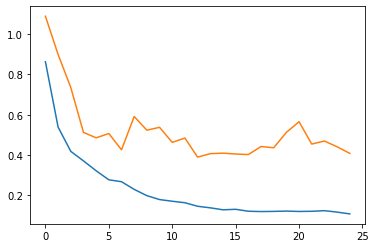

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [209]:
predicts = []
for i in dataxes:
    predict = model.predict(i)
    predicts.append(predict)

ValueError: x and y must have same first dimension, but have shapes (0,) and (10,)

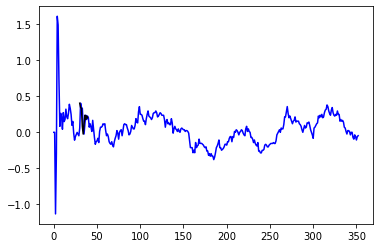

In [210]:
for j in range(len(dataxes)):
    plt.plot(sanne[j], c='blue')
    for i in range(len(datayes[j])):
        plt.plot(range(i+look_back,i+look_back+look_forward), datayes[j][i], c='black')
        plt.plot(range(i+look_back,i+look_forward+look_forward), predicts[j][i], c='red') #JEG tror det er noe feil her

    #plt.plot(range(0,15), datay[19], label='true')
    #plt.plot(range(1,16), datay[20], label='true')
    #plt.plot(range(1,16), predict[20], label='predicted')
    #plt.legend()
    plt.title('Prediction ')
    #plt.savefig('images/RNN_15_ahead')
    plt.show()


In [85]:
predict[0]

array([0.76824886, 0.98426884, 1.1329707 , 0.989848  , 1.1416246 ,
       1.0954686 , 0.9367621 , 0.94854134, 0.5770784 , 0.5705154 ,
       0.5571046 , 0.36905763, 0.28623486, 0.27843568, 0.05921907],
      dtype=float32)

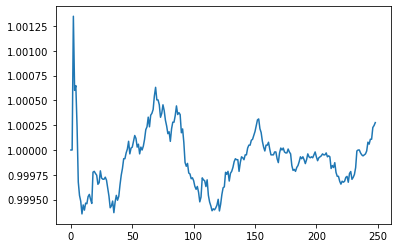

In [120]:
plt.plot(data.sma30_derivert)
#plt.plot(data.sma5_derivert)

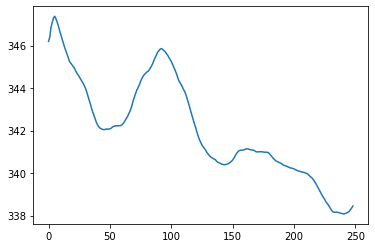

In [121]:
plt.plot(data.open_30_sma)
#plt.plot(data.sma5_derivert)

In [53]:
# Save model

#model.save('rnn_model')

INFO:tensorflow:Assets written to: rnn_model\assets


In [56]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0223-158D

 Directory of C:\Users\Stian\Documents\School\99. Div\intradag

19.09.2020  00.30    <DIR>          .
19.09.2020  00.30    <DIR>          ..
16.08.2020  17.38    <DIR>          .idea
01.09.2020  19.48    <DIR>          .ipynb_checkpoints
24.08.2020  21.27    <DIR>          data
26.08.2020  22.16    <DIR>          history
18.09.2020  19.30    <DIR>          images
25.08.2020  13.08    <DIR>          lib
30.08.2020  10.25           514ÿ958 make_model.ipynb
19.09.2020  00.30    <DIR>          models
29.08.2020  11.29               664 README.md
19.09.2020  00.29           132ÿ506 RNN_trial.ipynb
16.08.2020  17.14         3ÿ922ÿ732 smadaytrade.ipynb
01.09.2020  20.07           775ÿ971 use_model.ipynb
17.08.2020  12.53    <DIR>          __pycache__
               5 File(s)      5ÿ346ÿ831 bytes
              10 Dir(s)  75ÿ003ÿ355ÿ136 bytes free
